In [119]:
#!/usr/bin/env python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import multiprocessing
import time

import numpy as np
import pandas as pd

from typing import Any, Optional, Tuple

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tqdm import tqdm

import io
from PIL import Image
import tensorflow as tf

from sklearn.model_selection import train_test_split
from random import random
from skimage.io import imread, concatenate_images
from skimage.io import MultiImage
# import skimage.io as io
import apex.amp as amp
import matplotlib.pyplot as plt
%matplotlib.inline
IN_KERNEL = os.environ.get('KAGGLE_WORKING_DIR') is not None
MIN_SAMPLES_PER_CLASS = 50
BATCH_SIZE = 512
LEARNING_RATE = 1e-3
LR_STEP = 3
LR_FACTOR = 0.5
NUM_WORKERS = int(multiprocessing.cpu_count() / 2)
# MAX_STEPS_PER_EPOCH = 15000
MAX_STEPS_PER_EPOCH = 2 ** 32
NUM_EPOCHS = 2 ** 32
LOG_FREQ = 500
NUM_TOP_PREDICTS = 1
TIME_LIMIT = 9 * 60 * 60
IMAGE_SIZE = 64
ORIGINAL_IMAGE_SIZE = 299
CHECKPOINT_PATH = "checkpoints_64_50_filtered/"

CHECKPOINT_NAME = "checkpoints_25"
PREDICTION_FILE = "submission_kernel_64_50_cleaned"
TRAIN_CSV = "train_cleaned"
# TRAIN_CSV = "train"
# csv_dir = "/hdd/kaggle/landmarks/csv/"
csv_dir = "/home/daniel/kaggle/landmarks/csv/"
PREDICT_ONLY = True

class Tensorboard:
    def __init__(self, logdir):
        self.writer = tf.summary.FileWriter(logdir)

    def close(self):
        self.writer.close()

    def log_scalar(self, tag, value, global_step):
        summary = tf.Summary()
        summary.value.add(tag=tag, simple_value=value)
        self.writer.add_summary(summary, global_step=global_step)
        self.writer.flush()
        
    def log_histogram(self, tag, values, global_step, bins):
        counts, bin_edges = np.histogram(values, bins=bins)

        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        bin_edges = bin_edges[1:]

        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        summary = tf.Summary()
        summary.value.add(tag=tag, histo=hist)
        self.writer.add_summary(summary, global_step=global_step)
        self.writer.flush()

    def log_image(self, tag, img, global_step):
        s = io.BytesIO()
        Image.fromarray(img).save(s, format='png')

        img_summary = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                   height=img.shape[0],
                                   width=img.shape[1])

        summary = tf.Summary()
        summary.value.add(tag=tag, image=img_summary)
        self.writer.add_summary(summary, global_step=global_step)
        self.writer.flush()

    def log_plot(self, tag, figure, global_step):
        plot_buf = io.BytesIO()
        figure.savefig(plot_buf, format='png')
        plot_buf.seek(0)
        img = Image.open(plot_buf)
        img_ar = np.array(img)

        img_summary = tf.Summary.Image(encoded_image_string=plot_buf.getvalue(),
                                   height=img_ar.shape[0],
                                   width=img_ar.shape[1])

        summary = tf.Summary()
        summary.value.add(tag=tag, image=img_summary)
        self.writer.add_summary(summary, global_step=global_step)
        self.writer.flush()

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, mode: str) -> None:
        print(f'creating data loader - {mode}')
        assert mode in ['train', 'val', 'test']

        self.df = dataframe
        self.mode = mode

        if self.mode == "test":
            transforms_list = [
                transforms.CenterCrop(ORIGINAL_IMAGE_SIZE),
                transforms.Resize(IMAGE_SIZE)
            ]
        else:
            transforms_list = [
                transforms.Resize(IMAGE_SIZE)
            ]

        if self.mode == 'train':
            transforms_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.RandomResizedCrop(IMAGE_SIZE),
                    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                                            scale=(0.8, 1.2), shear=15,
                                            resample=Image.BILINEAR)
                ])
            ])


        transforms_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
        ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index: int) -> Any:
        ''' Returns: tuple (sample, target) '''
        filename = self.df.id.values[index]

        part = 1 if self.mode == 'test' or filename[0] in '01234567' else 2
        directory = 'test' if self.mode == 'test' else 'train_' + filename[0]
        # sample = Image.open(f'../input/google-landmarks-2019-64x64-part{part}/{directory}/{self.mode}_64/{filename}.jpg')
        if self.mode != "val":
            sample = Image.open(f'/home/daniel/kaggle/landmarks/data_kernel/{self.mode}/{self.mode}_{ORIGINAL_IMAGE_SIZE}/{filename}.jpg')
        else:
            sample = Image.open(f'/home/daniel/kaggle/landmarks/data_kernel/train/train_{ORIGINAL_IMAGE_SIZE}/{filename}.jpg')
        assert sample.mode == 'RGB'

        image = self.transforms(sample)

        if self.mode == 'test':
            return image
        else:
            return image, self.df.landmark_id.values[index]

    def __len__(self) -> int:
        return self.df.shape[0]

def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor) -> float:
    ''' Simplified GAP@1 metric: only one prediction per sample is supported '''
    assert len(predicts.shape) == 1
    assert len(confs.shape) == 1
    assert len(targets.shape) == 1
    assert predicts.shape == confs.shape and confs.shape == targets.shape

    _, indices = torch.sort(confs, descending=True)

    confs = confs.cpu().numpy()
    predicts = predicts[indices].cpu().numpy()
    targets = targets[indices].cpu().numpy()

    res, true_pos = 0.0, 0

    for i, (c, p, t) in enumerate(zip(confs, predicts, targets)):
        rel = int(p == t)
        true_pos += rel

        res += true_pos / (i + 1) * rel

    res /= targets.shape[0] # FIXME: incorrect, not all test images depict landmarks
    return res

class AverageMeter:
    ''' Computes and stores the average and current value '''
    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def load_data() -> 'Tuple[DataLoader[np.ndarray], DataLoader[np.ndarray], LabelEncoder, int]':
    torch.multiprocessing.set_sharing_strategy('file_system')
    cudnn.benchmark = True

    # only use classes which have at least MIN_SAMPLES_PER_CLASS samples
    print('loading data...')
    df = pd.read_csv(csv_dir + f'{TRAIN_CSV}.csv')
    df.drop(columns='url', inplace=True)

    counts = df.landmark_id.value_counts()
    selected_classes = counts[counts >= MIN_SAMPLES_PER_CLASS].index
    num_classes = selected_classes.shape[0]
    print('classes with at least N samples:', num_classes)

    train_df = df.loc[df.landmark_id.isin(selected_classes)].copy()

    print('train_df', train_df.shape)
    train_exists = lambda img: os.path.exists(f'/home/daniel/kaggle/landmarks/all_images_resized_{ORIGINAL_IMAGE_SIZE}/{img}.jpg')
    train_df = train_df.loc[train_df.id.apply(train_exists)].copy()
    print('train_df after filtering', train_df.shape)

    y = train_df.pop('landmark_id')
    x = train_df
    # train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.01, random_state=42, stratify=y)
    train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.01, random_state=42, stratify=y)
    train_x["landmark_id"] = train_y
    val_x["landmark_id"] = val_y

    train_df = train_x
    val_df = val_x

    print(f"Train length: {len(train_df)} Val length: {len(val_df)}")

    test_df = pd.read_csv(csv_dir + 'test.csv', dtype=str)
    test_df.drop(columns='url', inplace=True)
    print('test_df', test_df.shape)

    # filter non-existing test images
    # exists = lambda img: os.path.exists(f'../input/google-landmarks-2019-64x64-part1/test/test_64/{img}.jpg')
    exists = lambda img: os.path.exists(f'/home/daniel/kaggle/landmarks/test_images_raw/{img}.jpg')
    test_df = test_df.loc[test_df.id.apply(exists)].copy()
    print('test_df after filtering', test_df.shape)
    assert test_df.shape[0] > 112000
    # assert test_df.shape[0] > 117703

    label_encoder = LabelEncoder()
    label_encoder.fit(train_df.landmark_id.values)
    print('found classes', len(label_encoder.classes_))
    assert len(label_encoder.classes_) == num_classes

    train_df.landmark_id = label_encoder.transform(train_df.landmark_id)
    val_df.landmark_id = label_encoder.transform(val_df.landmark_id)

    train_dataset = ImageDataset(train_df, mode='train')
    test_dataset = ImageDataset(test_df, mode='test')
    val_dataset = ImageDataset(val_df, mode='val')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

    return train_loader, val_loader, test_loader, label_encoder, num_classes

def train(train_loader: Any, model: Any, criterion: Any, optimizer: Any,
          epoch: int, lr_scheduler: Any, tensorboard: Any) -> None:
    print(f'epoch {epoch}')
    batch_time = AverageMeter()
    losses = AverageMeter()
    avg_score = AverageMeter()

    model.train()
    num_steps = min(len(train_loader), MAX_STEPS_PER_EPOCH)

    print(f'total batches: {num_steps}')

    end = time.time()
    lr_str = ''

    global_step = (epoch - 1) * len(train_loader)

    for i, (input_, target) in enumerate(train_loader):
        global_step += 1
        if i >= num_steps:
            break

        output = model(input_.cuda())
        loss = criterion(output, target.cuda())

        confs, predicts = torch.max(output.detach(), dim=1)
        avg_score.update(GAP(predicts, confs, target))

        losses.update(loss.data.item(), input_.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % LOG_FREQ == 0:
            tensorboard.log_scalar("train_step_loss", losses.val, global_step)
            tensorboard.log_scalar("train_step_gap", avg_score.val, global_step)

            print(f'{epoch} [{i}/{num_steps}]\t'
                        f'time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                        f'loss {losses.val:.4f} ({losses.avg:.4f})\t'
                        f'GAP {avg_score.val:.4f} ({avg_score.avg:.4f})'
                        + lr_str)

        if has_time_run_out():
            break

    avg_epoch_loss = losses.avg
    avg_epoch_gap = avg_score.avg

    tensorboard.log_scalar("train_epoch_loss", avg_epoch_loss, epoch)
    tensorboard.log_scalar("train_epoch_gap", avg_epoch_gap, epoch)

    torch.save({
        'epoch': epoch,
        'classifier': model.fc,
        'model_state_dict': model.state_dict(),
        'optimizer': optimizer,
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': losses.avg,
        'gap': avg_score.avg,
        'global_step': global_step,
    }, CHECKPOINT_PATH + "checkpoints_{}".format(epoch))

    print(f' * average GAP on train {avg_score.avg:.4f}')

def inference(data_loader: Any, model: Any) -> Tuple[torch.Tensor, torch.Tensor,
                                                     Optional[torch.Tensor]]:
    ''' Returns predictions and targets, if any. '''
    model.eval()

    activation = nn.Softmax(dim=1)
    all_predicts, all_confs, all_targets, all_predicts_gap, all_confs_gap = [], [], [], [], []

    print("Data loader length", len(data_loader))
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, disable=IN_KERNEL)):
            if data_loader.dataset.mode != 'test':
                input_, target = data
            else:
                input_, target = data, None

            output = model(input_.cuda())
            output = activation(output)

            confs, predicts = torch.topk(output, NUM_TOP_PREDICTS)
            confs_gap, predicts_gap = torch.max(output.detach(), 1)
            all_confs.append(confs)
            all_predicts.append(predicts)
            all_predicts_gap.append(predicts_gap)
            all_confs_gap.append(confs_gap)

            if target is not None:
                all_targets.append(target)

    predicts = torch.cat(all_predicts)
    confs = torch.cat(all_confs)
    targets = torch.cat(all_targets) if len(all_targets) else None
    predicts_gap = torch.cat(all_predicts_gap)
    confs_gap = torch.cat(all_confs_gap)

    return predicts, confs, targets, predicts_gap, confs_gap

def eval(val_loader: Any, train_loader: Any, model: Any, tensorboard: Any, epoch: int) -> np.ndarray:
    predicts_gpu, confs_gpu, targets_gpu, predicts_gap_gpu, confs_gap_gpu = inference(val_loader, model)
    val_gap = GAP(predicts_gap_gpu, confs_gap_gpu, targets_gpu)
    num_correct = torch.sum(predicts_gap_gpu.cpu() == targets_gpu.cpu())
    predicts, confs, targets = predicts_gpu.cpu().numpy(), confs_gpu.cpu().numpy(), targets_gpu.cpu().numpy()


    labels = [label_encoder.inverse_transform(pred) for pred in predicts]

    assert len(labels) == len(val_loader.dataset.df)

    print(f"Val GAP: {val_gap}, Num correct: {num_correct}")

    tensorboard.log_scalar("val_num_correct", num_correct, epoch)
    tensorboard.log_scalar("val_gap", val_gap, epoch)

    val_df = val_loader.dataset.df
    train_df = train_loader.dataset.df
    rand_idx = int(random() * len(val_df))

    sample_row = val_df.iloc[rand_idx]
    sample_target = sample_row["landmark_id"]
    sample_prediction = labels[rand_idx][0]

    try:
        sample_predict_image_name = train_df[train_df["landmark_id"] == sample_prediction]["id"].tolist()[0]
        sample_predict_image_path = f"/home/daniel/kaggle/landmarks/all_images_resized_{ORIGINAL_IMAGE_SIZE}/{sample_predict_image_name}.jpg"
        tensorboard.log_image("predicted_class_image", imread(sample_predict_image_path), epoch)
    except:
        print(sample_prediction)

    sample_correct_label_image_path = f"/home/daniel/kaggle/landmarks/all_images_resized_{ORIGINAL_IMAGE_SIZE}/{sample_row['id']}.jpg"

    tensorboard.log_image("correct_class_image", imread(sample_correct_label_image_path), epoch)


def generate_submission(test_loader: Any, model: Any, label_encoder: Any) -> np.ndarray:
    sample_sub = pd.read_csv(csv_dir + 'recognition_sample_submission.csv')

    predicts_gpu, confs_gpu, _, _, _ = inference(test_loader, model)
    predicts, confs = predicts_gpu.cpu().numpy(), confs_gpu.cpu().numpy()

    labels = [label_encoder.inverse_transform([pred]) for pred in predicts]
    print('labels')
    print(np.array(labels))
    print('confs')
    print(np.array(confs))

    sub = test_loader.dataset.df
    def concat(label: np.ndarray, conf: np.ndarray) -> str:
        return ' '.join([f'{L} {c}' for L, c in zip(label, conf)])
    sub['landmarks'] = [concat(label, conf) for label, conf in zip(labels, confs)]

    sample_sub = sample_sub.set_index('id')
    sub = sub.set_index('id')
    sample_sub.update(sub)

    sample_sub.to_csv(f'predictions/{PREDICTION_FILE}.csv')

def has_time_run_out() -> bool:
    return time.time() - global_start_time > TIME_LIMIT - 500


ERROR:root:Line magic function `%matplotlib.inline` not found.


In [120]:
tensorboard = Tensorboard(CHECKPOINT_PATH + "logdir")
global_start_time = time.time()
train_loader, val_loader, test_loader, label_encoder, num_classes = load_data()

model = torchvision.models.resnet50(pretrained=True)
model.avg_pool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.cuda()

if CHECKPOINT_NAME != None:
    checkpoint = torch.load(CHECKPOINT_PATH + CHECKPOINT_NAME)
    model.load_state_dict(checkpoint["model_state_dict"])
    epoch = int(checkpoint["epoch"]) + 1
    global_step = int(checkpoint["global_step"])
        
epoch = 1

loading data...
classes with at least N samples: 17143
train_df (1883754, 2)
train_df after filtering (1878903, 2)


/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train length: 1860113 Val length: 18790
test_df (117703, 1)
test_df after filtering (112779, 1)
found classes 17143


/home/daniel/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


creating data loader - train
creating data loader - test
creating data loader - val


In [67]:
predicts_gpu, confs_gpu, targets_gpu, predicts_gap_gpu, confs_gap_gpu = inference(val_loader, model)
val_gap = GAP(predicts_gap_gpu, confs_gap_gpu, targets_gpu)
num_correct = torch.sum(predicts_gap_gpu.cpu() == targets_gpu.cpu())
predicts, confs, targets = predicts_gpu.cpu().numpy(), confs_gpu.cpu().numpy(), targets_gpu.cpu().numpy()


labels = [label_encoder.inverse_transform(pred) for pred in predicts]

assert len(labels) == len(val_loader.dataset.df)

  0%|          | 0/37 [00:00<?, ?it/s]

Data loader length 37


100%|██████████| 37/37 [00:07<00:00,  5.70it/s]


In [68]:
val_df = val_loader.dataset.df
train_df = train_loader.dataset.df

In [69]:
print(len(train_df))
labels_list = [l[0] for l in labels]
labels_list[:10]

1860113


[154960, 105665, 186453, 31898, 92275, 133530, 95411, 146058, 83653, 77124]

In [243]:
rand_idx = int(random() * len(val_df))

sample_row = val_df.iloc[rand_idx]
sample_target = sample_row["landmark_id"]
sample_prediction = int(predicts[rand_idx])
print(sample_row)
print(sample_prediction)
print(sample_target)

id             df98b6d640f8cee5
landmark_id                7849
Name: 1868938, dtype: object
7849
7849


In [244]:
sample_predict_image_name = train_df[train_df["landmark_id"] == sample_prediction]["id"].tolist()[0]
sample_predict_image_path = f"/home/daniel/kaggle/landmarks/all_images_resized_{ORIGINAL_IMAGE_SIZE}/{sample_predict_image_name}.jpg"
sample_correct_label_image_path = f"/home/daniel/kaggle/landmarks/all_images_resized_{ORIGINAL_IMAGE_SIZE}/{sample_row['id']}.jpg"
print(sample_predict_image_path)

/home/daniel/kaggle/landmarks/all_images_resized_299/8d62c6fd68050792.jpg


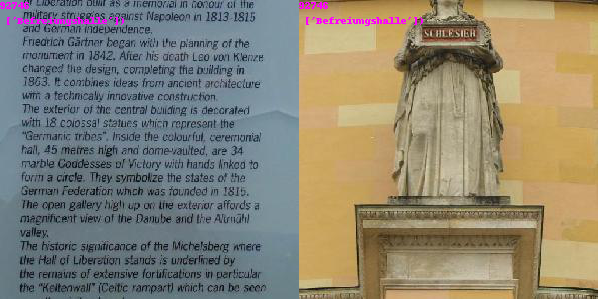

In [245]:
from PIL import ImageDraw 
EXPANDED_DESCRIPTIONS = pd.read_csv("csv/expanded_landmarks_descriptions.csv", names=["id", "description"])

def image_append_text(image_path, landmark_id):
    landmark_id_decoded = label_encoder.inverse_transform([landmark_id])[0]
    description = EXPANDED_DESCRIPTIONS[EXPANDED_DESCRIPTIONS["id"] == landmark_id_decoded]["description"].tolist()[0]
    description = "\n".join(description.split(",")[1:])
    description = f'{landmark_id_decoded}\n{description}'
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    draw.text((0, 0),description,(255,0,255))
    
    return img
    
# images = [Image.open(x) for x in [sample_predict_image_path, sample_correct_label_image_path]]
images = [image_append_text(sample_predict_image_path,sample_prediction), image_append_text(sample_correct_label_image_path,sample_target)]

widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
    
new_im

In [227]:
tensorboard.log_image("predicted_and_target_image", numpy.asarray(new_im), epoch)

In [51]:
8949 in train_df.landmark_id.values

True

In [48]:
sample_prediction in train_df.landmark_id.values

False

In [49]:
predicts

array([[13071],
       [ 8949],
       [15742],
       ...,
       [ 9613],
       [16246],
       [ 9175]])